In [1]:
#!pip install tensorflow_addons
!pip install keras-flops

In [5]:
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
import scipy

from tensorflow.keras import optimizers

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Input, Flatten, BatchNormalization, Dense
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
import matplotlib.pyplot as plt
import gc

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu,True)

In [ ]:
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
(train_data, train_label), (test_data, test_label) = cifar10.load_data()
train_label = to_categorical(train_label)
test_label = to_categorical(test_label)
train_data = (train_data/255.).astype("float32")
test_data = (test_data/255.).astype("float32")

NameError: name 'cifar10' is not defined

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data,train_label,random_state=seed,shuffle=True,train_size=0.9)

NameError: name 'train_test_split' is not defined

In [ ]:

batch_size = 32
datagen = ImageDataGenerator(rotation_range=15,
                             width_shift_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             height_shift_range=0.2,
                             shear_range=0.2
                            )

train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

In [ ]:
checkpoint_vit = ModelCheckpoint(r'C:\Users\fano\Desktop\weights\vit4_6.h5',
    verbose=1,
    monitor='val_loss',
    save_best_only=True,
    mode='auto'
)

In [ ]:
class PatchEmbedding(tf.keras.layers.Layer):
  def __init__(self , size , num_of_patches , projection_dim):
    super().__init__()

    self.size=size
    self.num_of_patches= num_of_patches + 1
    self.projection_dim=projection_dim

    self.projection=tf.keras.layers.Dense(projection_dim)

    self.clsToken= tf.Variable(tf.keras.initializers.GlorotNormal()(shape=(1 , 1 , projection_dim)) , trainable=True)
    self.positionalEmbedding = tf.keras.layers.Embedding(self.num_of_patches , projection_dim)


  def call(self, inputs):
    patches = tf.image.extract_patches(inputs ,
                                       sizes=[1 , self.size , self.size , 1],
                                       strides=[1 , self.size , self.size , 1],
                                       rates=[1 ,1 ,1 ,1],
                                       padding="VALID",)
    patches=tf.reshape(patches, (tf.shape(inputs)[0], -1, self.size * self.size *3))
    patches= self.projection(patches)

    # repeat cls token length of batch size
    clsToken = tf.repeat(self.clsToken , tf.shape(inputs)[0] , 0)
    patches = tf.concat((clsToken, patches) , axis=1)
    # create position number for each patch
    positions = tf.range(0 , self.num_of_patches , 1)[tf.newaxis , ...]
    positionalEmbedding = self.positionalEmbedding(positions)

    #print(positionalEmbedding)
    patches= patches + positionalEmbedding
    return patches


In [ ]:
class TransformerLayer(tf.keras.layers.Layer):
  def __init__(self , d_model , heads , mlp_rate , dropout_rate=0.1):
    super().__init__()

    self.layernorm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.mha= tf.keras.layers.MultiHeadAttention(heads, d_model//heads , dropout=dropout_rate)

    self.layernorm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.mlp = tf.keras.Sequential([
                                    tf.keras.layers.Dense(d_model * mlp_rate , activation="gelu"),
                                    tf.keras.layers.Dropout(dropout_rate),
                                    tf.keras.layers.Dense(d_model , activation="gelu"),
                                    tf.keras.layers.Dropout(dropout_rate)
    ])
  def call(self , inputs , training=True):
    out_1 = self.layernorm_1(inputs)
    out_1 = self.mha(out_1 , out_1 ,training=training)
    out_1 = inputs + out_1

    out_2= self.layernorm_2(out_1)
    out_2=self.mlp(out_2 , training=training)
    out_2 = out_1 + out_2

    return out_2


In [ ]:
class TransformerEncoder(tf.keras.layers.Layer):
  def __init__(self , d_model , heads , mlp_rate , num_layers=1 , dropout_rate=0.1):
    super().__init__()

    self.encoders = [TransformerLayer(d_model , heads , mlp_rate , dropout_rate) for _ in range(num_layers)]

  def call(self , inputs , training=True):
    x =inputs

    for layer in self.encoders:
      x = layer(x , training=training)

    return x


In [ ]:
class ViT(tf.keras.Model):
  def __init__(self , num_classes , patch_size , num_of_patches , d_model , heads , num_layers , mlp_rate , dropout_rate=0.1):
    super().__init__()

    self.patchEmbedding = PatchEmbedding(patch_size , num_of_patches , d_model)
    self.encoder = TransformerEncoder(d_model , heads , mlp_rate  ,num_layers , dropout_rate)

    self.prediction = tf.keras.Sequential([
                                           tf.keras.layers.Dropout(0.3),
                                           tf.keras.layers.Dense(mlp_rate * d_model , activation="gelu"),
                                           tf.keras.layers.Dropout(0.2),
                                           tf.keras.layers.Dense(num_classes, activation="softmax")


  ])
  def call(self , inputs ,  training=True):
    patches = self.patchEmbedding(inputs)
    encoderResult = self.encoder(patches, training=training)

    clsResult = encoderResult[: , 0 , :]

    prediction = self.prediction(clsResult,
                                 training=training)
    return prediction


In [ ]:
# def scheduler(epoch, lr):
#     if epoch < 10:
#         return lr
#     else:
#         if epoch % 2:
#             return lr * tf.math.exp(-0.1)
#         else:
#             return lr

# callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
def lr_warmup_cosine_decay(global_step,
                           warmup_steps,
                           hold = 0,
                           total_steps=0,
                           start_lr=0.0001,
                           target_lr=1e-3):
    # Cosine decay
    learning_rate = 0.5 * target_lr * (1 + np.cos(np.pi * (global_step - warmup_steps - hold) / float(total_steps - warmup_steps - hold)))

    # Target LR * progress of warmup (=1 at the final warmup step)
    warmup_lr = target_lr * (global_step / warmup_steps)

    # Choose between `warmup_lr`, `target_lr` and `learning_rate` based on whether `global_step < warmup_steps` and we're still holding.
    # i.e. warm up if we're still warming up and use cosine decayed lr otherwise
    if hold > 0:
        learning_rate = np.where(global_step > warmup_steps + hold,
                                 learning_rate, target_lr)

    learning_rate = np.where(global_step < warmup_steps, warmup_lr, learning_rate)
    return learning_rate

In [ ]:
from tensorflow.keras import backend as K

class WarmupCosineDecay(tf.keras.callbacks.Callback):
    def __init__(self, total_steps=0, warmup_steps=0, start_lr=0.0001, target_lr=1e-3, hold=0):

        super(WarmupCosineDecay, self).__init__()
        self.start_lr = start_lr
        self.hold = hold
        self.total_steps = total_steps
        self.global_step = 1
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.lrs = []

    def on_epoch_end(self, epoch, logs=None):
        self.global_step = self.global_step + 1
        lr = self.model.optimizer.lr.numpy()
        self.lrs.append(lr)

    def on_epoch_begin(self, epoch, logs=None):
        lr = lr_warmup_cosine_decay(global_step=self.global_step,
                                    total_steps=self.total_steps,
                                    warmup_steps=self.warmup_steps,
                                    start_lr=self.start_lr,
                                    target_lr=self.target_lr,
                                    hold=self.hold)
        print(f"Learining rate is {lr}")
        K.set_value(self.model.optimizer.lr, lr)

In [ ]:
# If already batched
total_steps = 100
# If not batched
#total_steps = len(train_set)/config['BATCH_SIZE']*config['EPOCHS']
# 5% of the steps
warmup_steps = 10

callback = WarmupCosineDecay(total_steps=total_steps,
                             warmup_steps=warmup_steps,
                             hold=int(warmup_steps/2),
                             start_lr=0.0001,
                             target_lr=0.001)

In [ ]:
vitClassifier = ViT(num_classes=10, patch_size=16, num_of_patches=196,
                d_model=192, heads=3, num_layers=12,
                mlp_rate=4,dropout_rate=0.1)

In [ ]:
next(iter(train_generator))[0].shape

(32, 32, 32, 3)

In [ ]:
def build_model():
    inputs = Input(shape=(32,32,3))
    x = tf.keras.layers.Lambda(lambda image: tf.image.resize(image,(224,224)))(inputs)
    y = vitClassifier(x)

    return Model(inputs=inputs,outputs=y)


In [ ]:
vit = build_model()

In [ ]:
vit.summary()
vit.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    #optimizer = tf.keras.optimizers.SGD(lr=0.01,momentum=0.9),
    loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=[
      tf.keras.metrics.CategoricalAccuracy(name="accuracy")
  ],
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 vi_t (ViT)                  (None, 10)                5679946   
                                                                 
Total params: 5,679,946
Trainable params: 5,679,946
Non-trainable params: 0
_________________________________________________________________


C:\Users\fano\anaconda3\envs\rs\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history = vit.fit(train_generator,
                    epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[callback]
                   )
#print("\nTest Accuracy: ", accuracy_score(np.argmax(test_label, axis=1), np.argmax(model.predict(test_data), axis=1)))

Learining rate is 0.0001
Epoch 1/100
1407/1407 [==============================] - 272s 186ms/step - loss: 1.9960 - accuracy: 0.2589 - val_loss: 1.7524 - val_accuracy: 0.3572
Learining rate is 0.0002
Epoch 2/100
1407/1407 [==============================] - 263s 187ms/step - loss: 1.7311 - accuracy: 0.3601 - val_loss: 1.5539 - val_accuracy: 0.4148
Learining rate is 0.0003
Epoch 3/100
1407/1407 [==============================] - 264s 187ms/step - loss: 1.6038 - accuracy: 0.4168 - val_loss: 1.4240 - val_accuracy: 0.4710
Learining rate is 0.0004
Epoch 4/100
1407/1407 [==============================] - 265s 189ms/step - loss: 1.5237 - accuracy: 0.4462 - val_loss: 1.3908 - val_accuracy: 0.4944
Learining rate is 0.0005
Epoch 5/100
1407/1407 [==============================] - 265s 188ms/step - loss: 1.4873 - accuracy: 0.4634 - val_loss: 1.5096 - val_accuracy: 0.4662
Learining rate is 0.0006
Epoch 6/100
1407/1407 [==============================] - 261s 185ms/step - loss: 1.4580 - accuracy: 0.472

In [ ]:
# save the model !!!

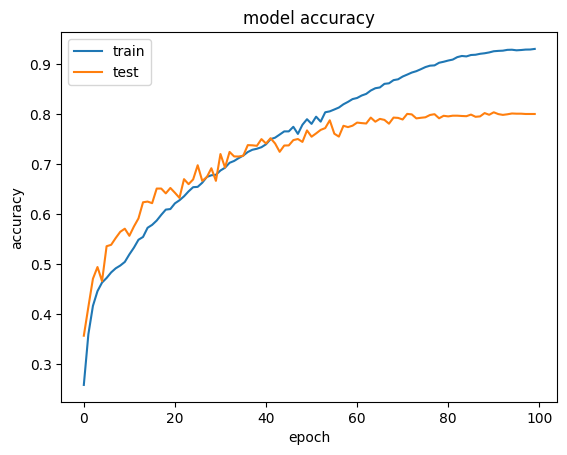

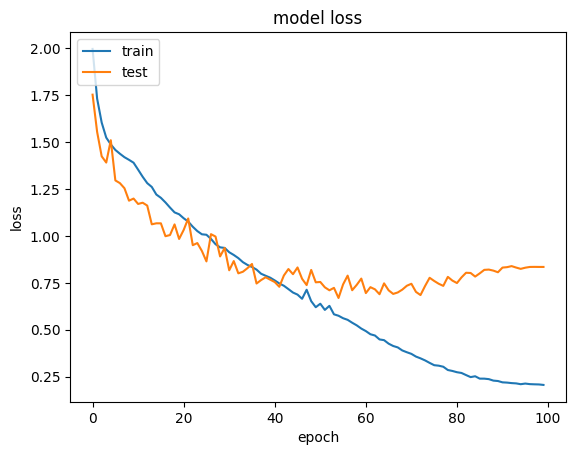

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
results = vit.evaluate(test_data,test_label, batch_size=32, verbose=1)
print("test loss, test acc:", results)

313/313 [==============================] - 19s 61ms/step - loss: 0.8199 - accuracy: 0.8014
test loss, test acc: [0.8198679685592651, 0.8014000058174133]
